<b> Install Prophet </b>
https://facebook.github.io/prophet/docs/installation.html

<b> Reference </b> 
https://facebook.github.io/prophet/docs/quick_start.html#python-api

In [9]:
import numpy as np
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

<b> Data </b>

The input to Prophet is always a dataframe with two columns: `ds` and `y`. The `ds` (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The `y` column must be numeric, and represents the measurement we wish to forecast.

As an example, let’s look at a time series of the log daily page views for the Wikipedia page for Peyton Manning. 

In [29]:
df = pd.read_csv('data/output_tmed.csv', index_col="fecha").reset_index(drop=False).rename(columns={'fecha': 'ds', 'tmed': 'y'})
df.head()

,ds,y
0,2000-01-01,9.0
1,2000-01-02,8.7
2,2000-01-03,9.2
3,2000-01-04,10.5
4,2000-01-05,9.8


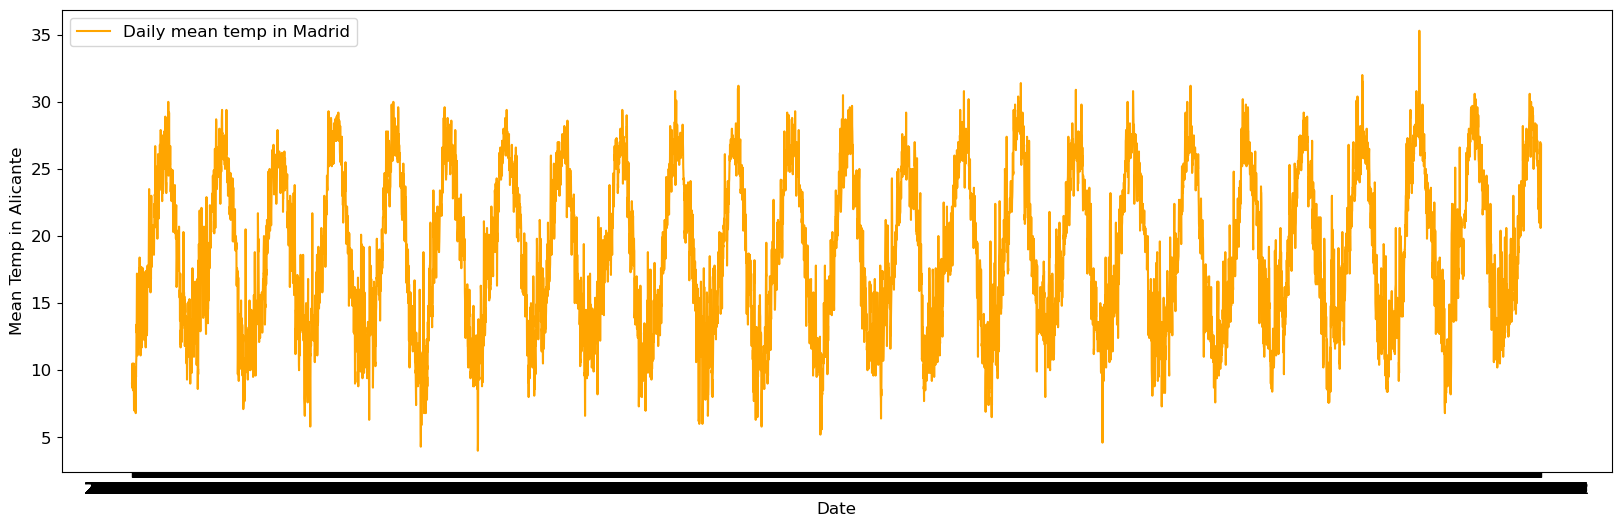

In [30]:
#see the TS plot

plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(df.ds, df.y, color='orange', label='Daily mean temp in Madrid')
ax.set_xlabel('Date')
ax.set_ylabel('Mean Temp in Alicante')
ax.legend(loc='upper left')

<b> I. Forecasting </b>

The basic model fitting and forecasting can be done by 

- creating a new Prophet project
- call `fit` to fit on the given historic data
- predictions are then made on a dataframe with a column ds containing the dates for which a prediction is to be made.

By default, Prophet uses the piecewise linear model for its forecast

In [32]:
#Prophet project
model = Prophet() #default trend = piece-wise linear model
                #default include weekly and yearly seasonalities

#Fit with default settings
model.add_seasonality(name='yearly', period=365, fourier_order=10)

model.fit(df)

#Fataframe with forecasting steps
future = model.make_future_dataframe(periods=365) #freq='D'
#Forecast
forecast = model.predict(future)
# fig = model.plot_components(forecast)


02:01:38 - cmdstanpy - INFO - Chain [1] start processing
02:01:39 - cmdstanpy - INFO - Chain [1] done processing


In [34]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast.to_csv('forecast/forecast_tmed_1y.csv', index=False)

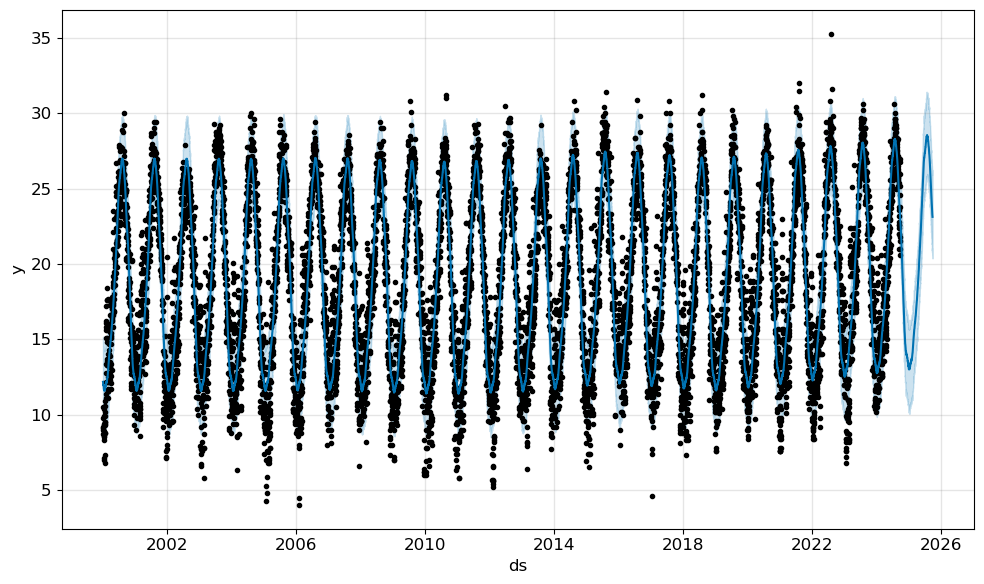

In [35]:
fig1 = model.plot(forecast)
# fig1.savefig('fig/forecast_plot.png', dpi=300, bbox_inches='tight')


In [37]:
#Save model
from prophet.serialize import model_to_json, model_from_json

with open('models/tmed_model.json', 'w') as fout:
    fout.write(model_to_json(model))  # Save model

# with open('serialized_model.json', 'r') as fin:
#     m = model_from_json(fin.read())  # Load model

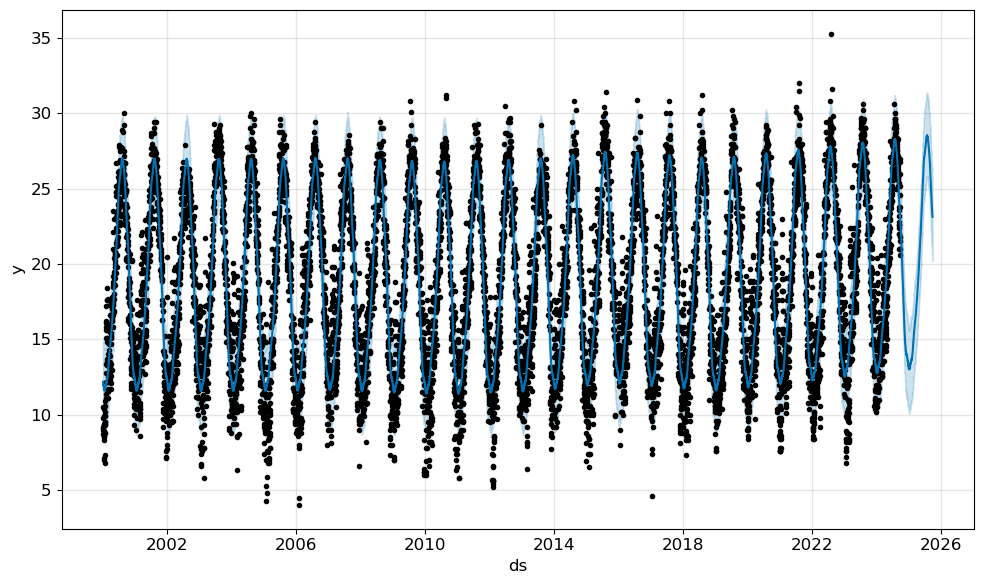

In [38]:
#load model
with open('models/tmed_model.json', 'r') as fin:
    loaded = model_from_json(fin.read())  # Load model

future2 = loaded.make_future_dataframe(periods=365) #freq='D'
#Forecast
forecast2 = loaded.predict(future2)
fig2 = loaded.plot(forecast2)

<b> VI. Cross Validation in Prophet </b>

Prophet includes functionality for time series cross validation to measure forecast error using historical data. You need choose:

- Initial train size
- Horizon: the period you want to forecast
- Period: the size of rolling window


In [84]:
model_data.iloc[731]

index               3657
ds            2016-12-31
city_name         Madrid
y             272.384074
temp_min      271.409259
temp_max      274.261111
rain_1h              0.0
clouds_all     30.185185
Name: 731, dtype: object

In [97]:
from prophet.diagnostics import cross_validation
forecast_cv = cross_validation(model, initial='730 days', period='180 days', horizon = '365 days')


  0%|          | 0/3 [00:00<?, ?it/s]

12:37:17 - cmdstanpy - INFO - Chain [1] start processing
12:37:18 - cmdstanpy - INFO - Chain [1] done processing
12:37:18 - cmdstanpy - INFO - Chain [1] start processing
12:37:18 - cmdstanpy - INFO - Chain [1] done processing
12:37:18 - cmdstanpy - INFO - Chain [1] start processing
12:37:18 - cmdstanpy - INFO - Chain [1] done processing


In [98]:
print(model_data.shape)
model_data

(1462, 8)


,index,ds,city_name,y,temp_min,temp_max,rain_1h,clouds_all
0,2,2014-12-31,Madrid,267.325000,267.325000,267.325000,0.0,0.000000
1,7,2015-01-01,Madrid,272.176652,272.176652,272.176652,0.0,0.000000
2,12,2015-01-02,Madrid,272.546417,272.546417,272.546417,0.0,5.291667
3,17,2015-01-03,Madrid,273.754031,273.754031,273.754031,0.0,0.000000
4,22,2015-01-04,Madrid,274.543271,274.543271,274.543271,0.0,0.000000
...,...,...,...,...,...,...,...,...
1457,7287,2018-12-27,Madrid,277.649167,276.587500,279.045833,0.0,6.166667
1458,7292,2018-12-28,Madrid,278.839167,277.691667,280.275000,0.0,6.000000
1459,7297,2018-12-29,Madrid,279.189167,278.233333,280.358333,0.0,0.000000
1460,7302,2018-12-30,Madrid,278.730417,277.316667,280.775000,0.0,0.000000


In [103]:
forecast_cv
forecast_cv.to_csv('output/forecast_cross_validation.csv', index=False)


In [104]:
#check performance 

from prophet.diagnostics import performance_metrics
forecast_perf = performance_metrics(forecast_cv) #by default start with 10% of the horizon
forecast_perf.to_csv('output/forecast_performance_metrics.csv', index=False)


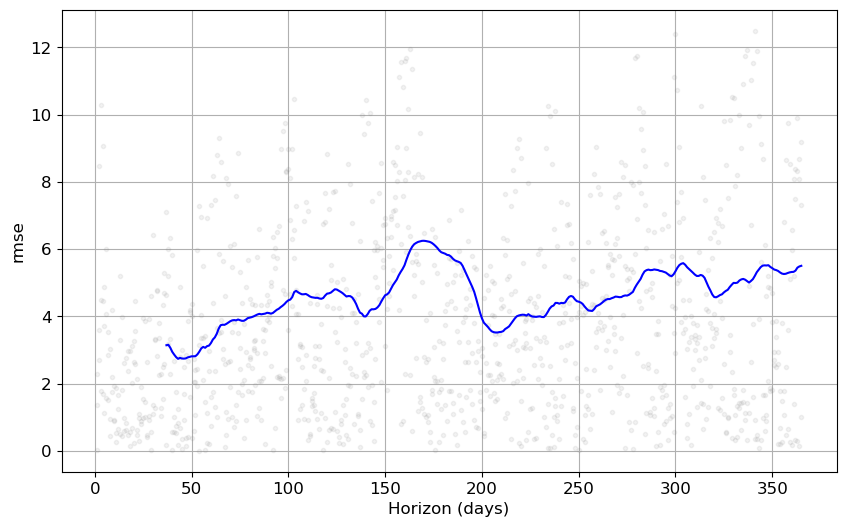

In [105]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(forecast_cv, metric='rmse')